In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [ ]:
original_data = pd.read_csv('Life Expectancy Data.csv')

In [ ]:
original_data.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# rename columns
original_data = original_data.rename({
                  'Life expectancy ': 'Life expectancy',
                  'infant deaths': 'Infant deaths', 
                  'percentage expenditure': 'Percentage expenditure',
                  'Measles ': 'Measles',
                  ' BMI ': 'BMI',
                  'under-five deaths ': 'Under-five deaths',
                  'Diphtheria ': 'Diphtheria',
                  ' HIV/AIDS': 'HIV/AIDS',
                  ' thinness  1-19 years': 'Thinness 1-19 years',
                  ' thinness 5-9 years': 'Thinness 5-9 years',
}, axis='columns')

original_data.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'Under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness 1-19 years',
       'Thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [ ]:
original_data.describe()

,Year,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [ ]:
# Filling NaNs
def imputer(data, feature, method):
    if method == "mode":
        data[feature] = data[feature].fillna(data[feature].mode()[0])
    elif method == "median":
        data[feature] = data[feature].fillna(data[feature].median())
    else:
        data[feature] = data[feature].fillna(data[feature].mean())

## Step 1

You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV)
  

In [ ]:
vars_subsample = [ 
                  'Life expectancy', # target 
                  # 'Country', # help to vis
                  'Status', # help to sample                  
                  'BMI', # target
                  'GDP', # target
                  'Adult Mortality', # predictor
                  'Infant deaths', # predictor
                  'Alcohol', # predictor
                  # 'Percentage expenditure',
                  # 'Hepatitis B',
                  # 'Measles',
                  # 'Under-five deaths', 
                  'Polio', # predictor
                  'Total expenditure', # predictor
                  'Diphtheria',  # predictor
                  # 'HIV/AIDS',
                  # 'Population',
                  # 'Thinness 1-19 years',
                  # 'Thinness 5-9 years',
                  # 'Income composition of resources',
                  'Schooling', # predictor
                  # 'Year',
]
# We skip status because it is used later as a categorial variable
predictors = vars_subsample[2:]
categorial = vars_subsample[1]
target = vars_subsample[0]

In [ ]:
data = original_data[vars_subsample].copy()
data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})

features_missing = data.columns[data.isna().any()]

for feature in features_missing:
  imputer(data, feature, method='mean')

In [ ]:
data.shape

(2938, 11)

In [ ]:
# (modified from http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)
def get_iqr_values(df_in, col_name):
    median = df_in[col_name].median()
    q1 = df_in[col_name].quantile(0.25) # 25th percentile / 1st quartile
    q3 = df_in[col_name].quantile(0.75) # 7th percentile / 3rd quartile
    iqr = q3-q1 #Interquartile range
    minimum  = q1-1.5*iqr # The minimum value or the |- marker in the box plot
    maximum = q3+1.5*iqr # The maximum value or the -| marker in the box plot
    return median, q1, q3, iqr, minimum, maximum

def remove_outliers(df_in, col_name):
    _, _, _, _, minimum, maximum = get_iqr_values(df_in, col_name)
    df_out = df_in.loc[(df_in[col_name] > minimum) & (df_in[col_name] < maximum)]
    return df_out

In [ ]:
# for var in vars_subsample[1:]:
#   data = remove_outliers(data, var)

In [ ]:
data.head()

,Life expectancy,Status,BMI,GDP,Adult Mortality,Infant deaths,Alcohol,Polio,Total expenditure,Diphtheria,Schooling
0,65.0,0,19.1,584.259210,263.0,62,0.01,6.0,8.16,65.0,10.1
1,59.9,0,18.6,612.696514,271.0,64,0.01,58.0,8.18,62.0,10.0
2,59.9,0,18.1,631.744976,268.0,66,0.01,62.0,8.13,64.0,9.9
3,59.5,0,17.6,669.959000,272.0,69,0.01,67.0,8.52,67.0,9.8
4,59.2,0,17.2,63.537231,275.0,71,0.01,68.0,7.87,68.0,9.5


------------------------------------------------
Predictor: BMI, target: Life expectancy


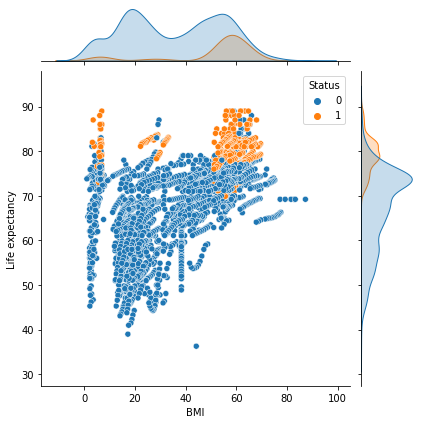

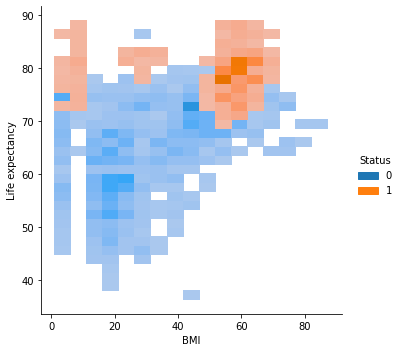

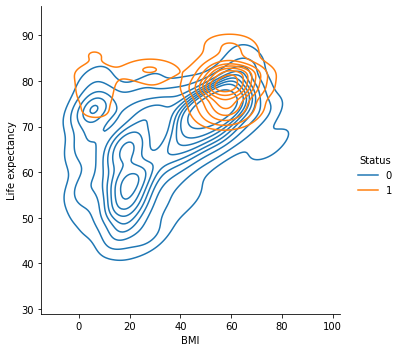

------------------------------------------------
Predictor: GDP, target: Life expectancy


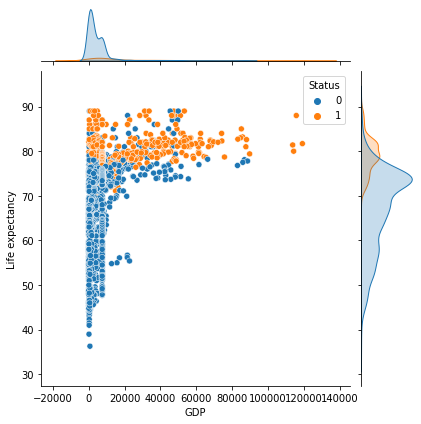

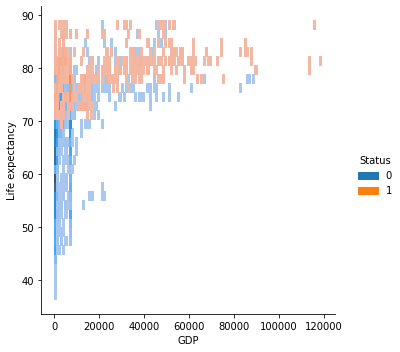

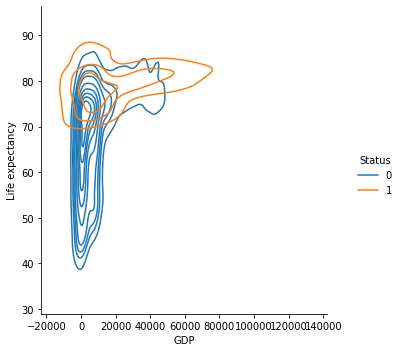

------------------------------------------------
Predictor: Adult Mortality, target: Life expectancy


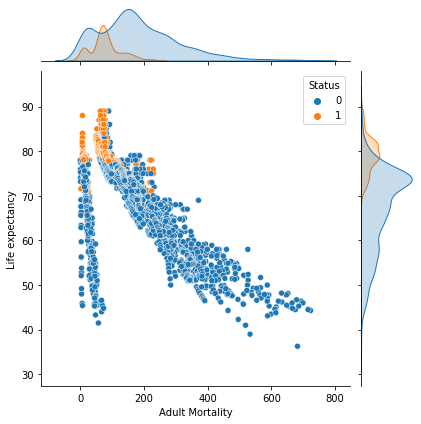

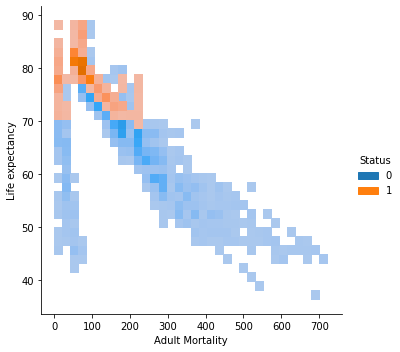

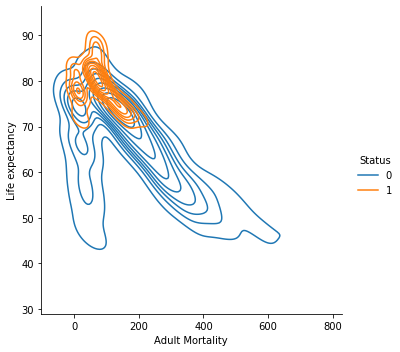

------------------------------------------------
Predictor: Infant deaths, target: Life expectancy


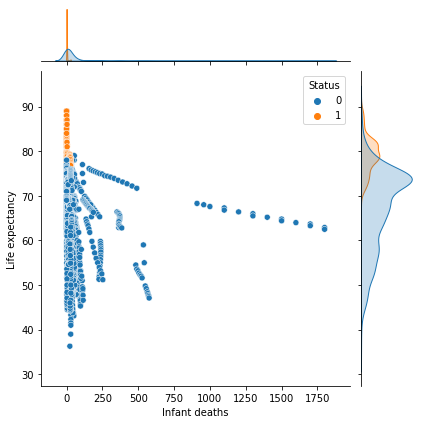

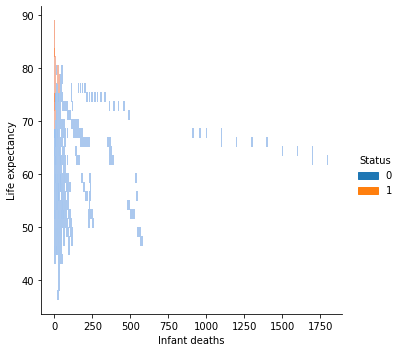

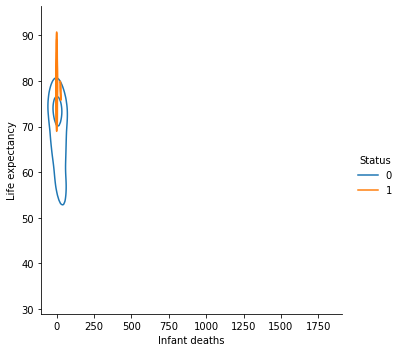

------------------------------------------------
Predictor: Alcohol, target: Life expectancy


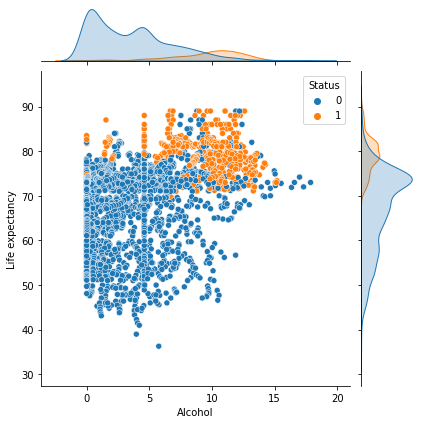

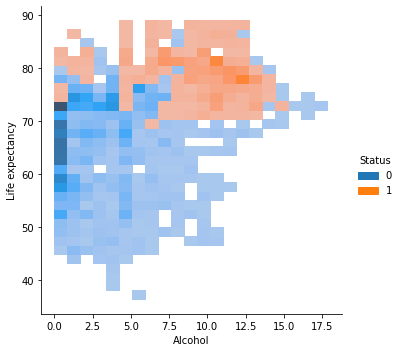

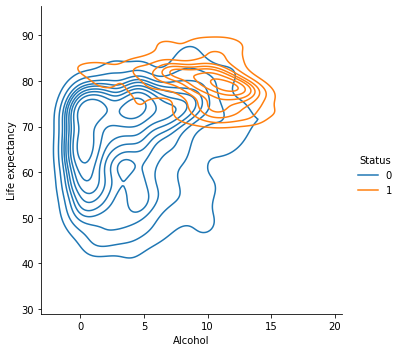

------------------------------------------------
Predictor: Polio, target: Life expectancy


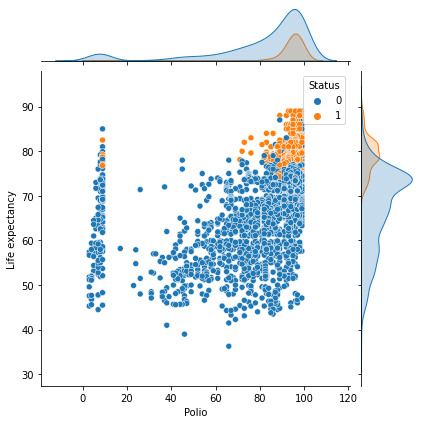

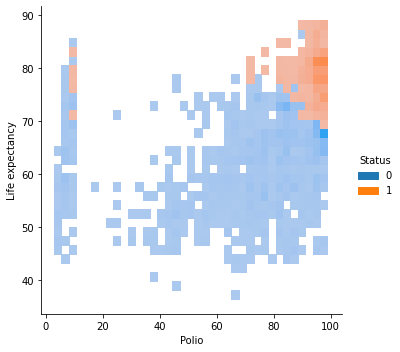

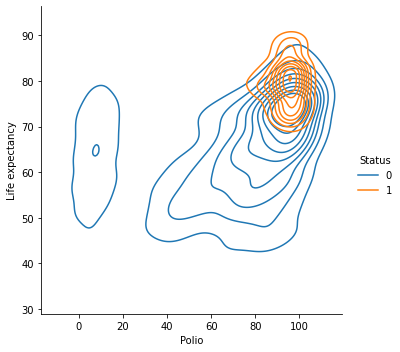

------------------------------------------------
Predictor: Total expenditure, target: Life expectancy


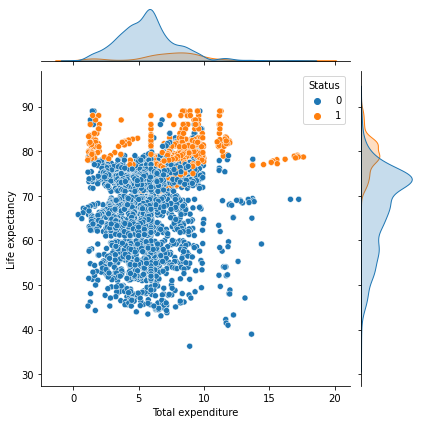

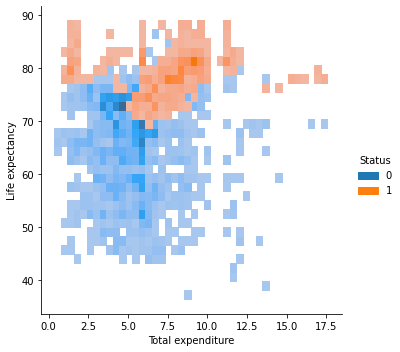

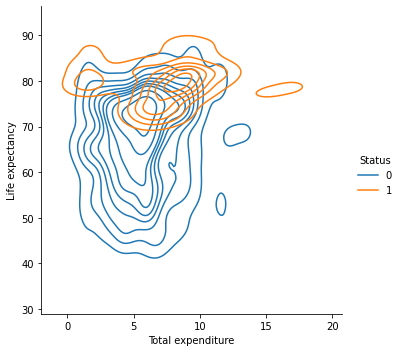

------------------------------------------------
Predictor: Diphtheria, target: Life expectancy


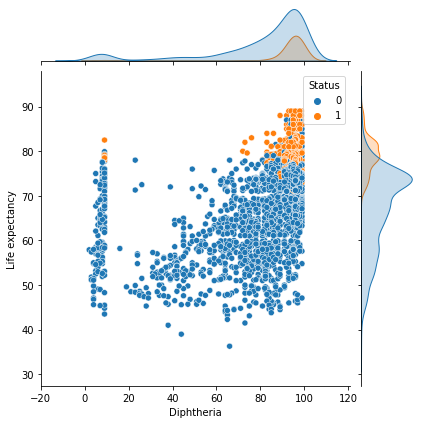

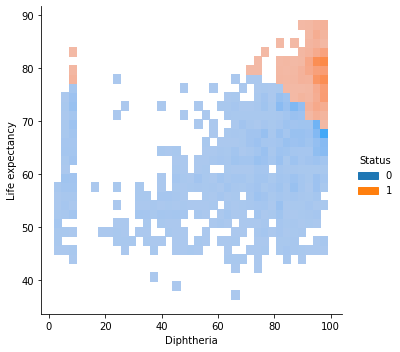

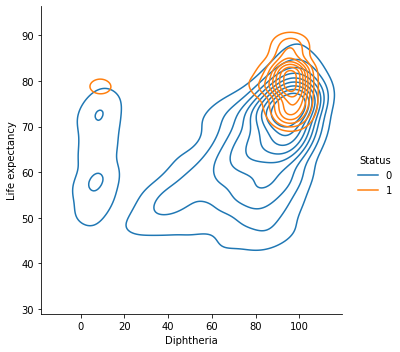

------------------------------------------------
Predictor: Schooling, target: Life expectancy


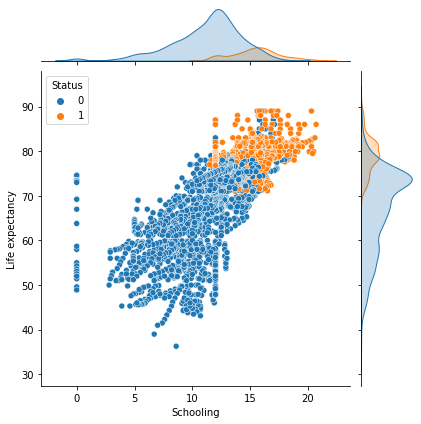

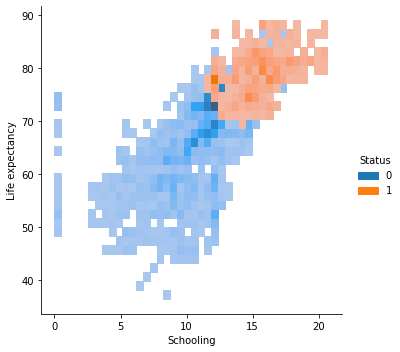

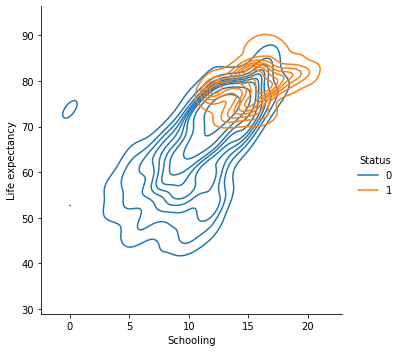

In [ ]:

def step1_plots(data, predictor, target, categorial):
  print('------------------------------------------------')
  print('Predictor: {}, target: {}'.format(predictor, target))
  sns.jointplot(data=data, x=predictor, y=target, hue=categorial)
  sns.displot(data=data, x=predictor, y=target, hue=categorial)
  sns.displot(data=data, x=predictor, y=target, kind='kde', hue=categorial)
  plt.show()

for predictor in predictors:
  step1_plots(data, predictor, target, categorial)


## Step 2

You need to make an estimation of multivariate mathematical expectation and
variance.

In [ ]:
data.mean()

Life expectancy        69.224932
Status                  0.174268
BMI                    38.321247
GDP                  7483.158469
Adult Mortality       164.796448
Infant deaths          30.303948
Alcohol                 4.602861
Polio                  82.550188
Total expenditure       5.938190
Diphtheria             82.324084
Schooling              11.992793
dtype: float64

In [ ]:
data.var()

Life expectancy      9.039522e+01
Status               1.439478e-01
BMI                  3.971123e+02
GDP                  1.725755e+08
Adult Mortality      1.539592e+04
Infant deaths        1.390666e+04
Alcohol              1.533731e+01
Polio                5.453226e+02
Total expenditure    5.761315e+00
Diphtheria           5.588531e+02
Schooling            1.065619e+01
dtype: float64

## Step 3

You need to make a non-parametric estimation of conditional distributions,
mathematical expectations and variances.


------------------------------------------------
Mean of Life expectancy if Status = 0
67.12017696493821

Variance of Life expectancy if Status = 0
80.79356523644911

Distributions:


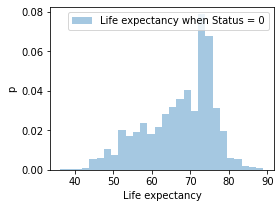

------------------------------------------------
Mean of Life expectancy if Status = 1
79.19785156249996

Variance of Life expectancy if Status = 1
15.452304572835123

Distributions:


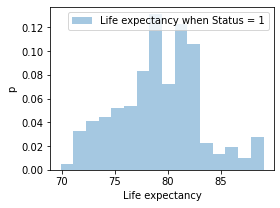

------------------------------------------------
Mean of Status if Status = 0
0.0

Variance of Status if Status = 0
0.0

Distributions:


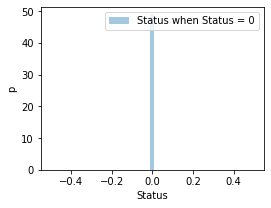

------------------------------------------------
Mean of Status if Status = 1
1.0

Variance of Status if Status = 1
0.0

Distributions:


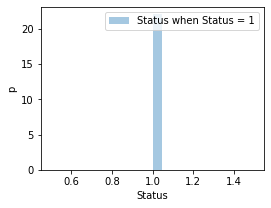

------------------------------------------------
Mean of BMI if Status = 0
35.47577179840064

Variance of BMI if Status = 0
372.15883984187394

Distributions:


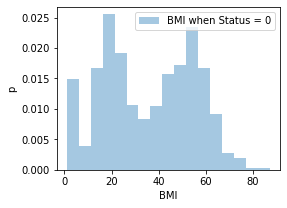

------------------------------------------------
Mean of BMI if Status = 1
51.80390624999999

Variance of BMI if Status = 1
295.7309436154602

Distributions:


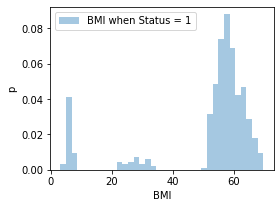

------------------------------------------------
Mean of GDP if Status = 0
4792.531043856161

Variance of GDP if Status = 0
66132090.15757532

Distributions:


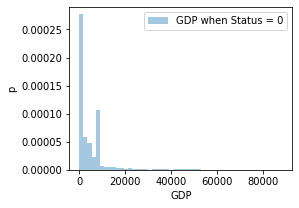

------------------------------------------------
Mean of GDP if Status = 1
20232.107949089597

Variance of GDP if Status = 1
480827290.18306303

Distributions:


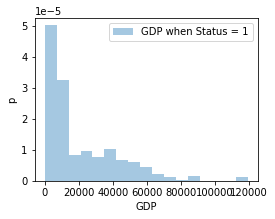

------------------------------------------------
Mean of Adult Mortality if Status = 0
182.75884768378992

Variance of Adult Mortality if Status = 0
16311.287262000733

Distributions:


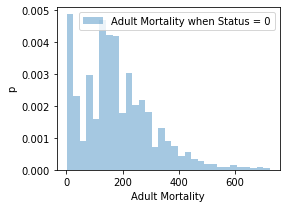

------------------------------------------------
Mean of Adult Mortality if Status = 1
79.685546875

Variance of Adult Mortality if Status = 1
2292.2629609527885

Distributions:


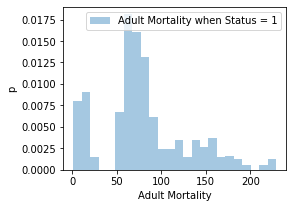

------------------------------------------------
Mean of Infant deaths if Status = 0
36.384171475680134

Variance of Infant deaths if Status = 0
16626.170701931787

Distributions:


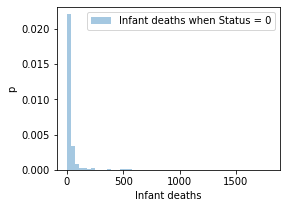

------------------------------------------------
Mean of Infant deaths if Status = 1
1.494140625

Variance of Infant deaths if Status = 1
21.02931980797456

Distributions:


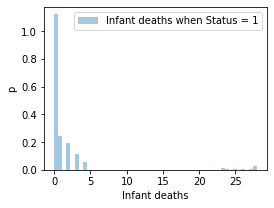

------------------------------------------------
Mean of Alcohol if Status = 0
3.5606697818098203

Variance of Alcohol if Status = 0
10.518722450653012

Distributions:


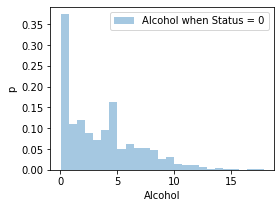

------------------------------------------------
Mean of Alcohol if Status = 1
9.541054886798463

Variance of Alcohol if Status = 1
8.644301078757541

Distributions:


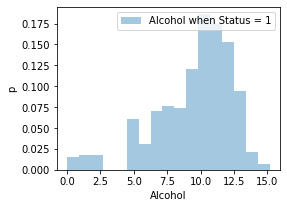

------------------------------------------------
Mean of Polio if Status = 0
80.18938729595759

Variance of Polio if Status = 0
603.9594025103117

Distributions:


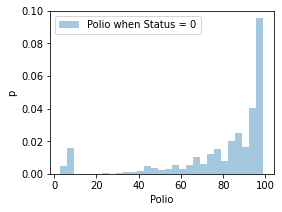

------------------------------------------------
Mean of Polio if Status = 1
93.736328125

Variance of Polio if Status = 1
116.28846242049902

Distributions:


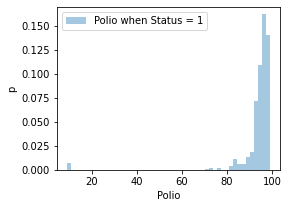

------------------------------------------------
Mean of Total expenditure if Status = 0
5.618482592100824

Variance of Total expenditure if Status = 0
4.599378870830687

Distributions:


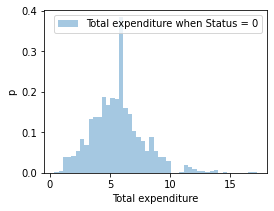

------------------------------------------------
Mean of Total expenditure if Status = 1
7.4530509080014635

Variance of Total expenditure if Status = 1
8.502112139306051

Distributions:


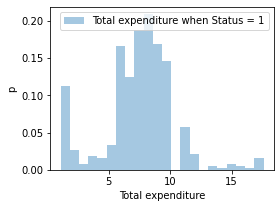

------------------------------------------------
Mean of Diphtheria if Status = 0
79.97038647494439

Variance of Diphtheria if Status = 0
611.9540199666353

Distributions:


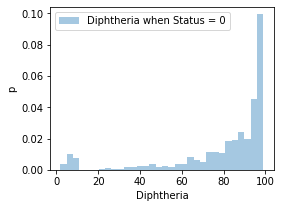

------------------------------------------------
Mean of Diphtheria if Status = 1
93.4765625

Variance of Diphtheria if Status = 1
157.02880381604697

Distributions:


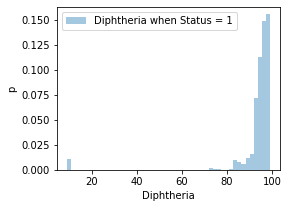

------------------------------------------------
Mean of Schooling if Status = 0
11.255923813343424

Variance of Schooling if Status = 0
8.926780452850407

Distributions:


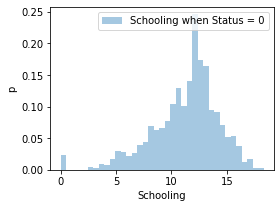

------------------------------------------------
Mean of Schooling if Status = 1
15.484285261824335

Variance of Schooling if Status = 1
4.091913258301034

Distributions:


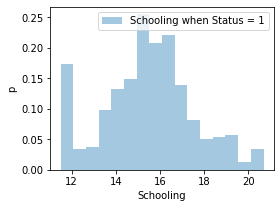

In [ ]:
def step3_plots(data, categorial, vars):
  categorial_values = set(data[categorial])

  for var in vars:
    for categorial_value in categorial_values:
      sample = data[data[categorial] == categorial_value]

      print('------------------------------------------------')
      print('Mean of ' + var + ' if ' + categorial + ' = ' + 
            str(categorial_value))
      print(sample.mean()[var])
      print()
      print('Variance of ' + var + ' if ' + categorial + ' = ' + 
            str(categorial_value))
      print(sample.var()[var])
      print()
      print('Distributions:')
      plt.figure(figsize=(4, 3))
      min_var, max_var = sample[var].min(), sample[var].max()
      x = np.linspace(min_var, max_var, len(sample))
    
      sns.distplot(sample[var],
                  kde=False,
                  norm_hist=True, 
                  label=var + ' when ' + categorial + ' = ' +
                  str(categorial_value))
    
      plt.ylabel('p')
      plt.legend()
      plt.show()

step3_plots(data, categorial, vars_subsample)

## Step 4

In [ ]:
def pearson_data(x, y, a=0.05):
  r, p = scipy.stats.pearsonr(x, y)
  r_z = np.arctanh(r)
  se = 1 / np.sqrt(x.size-3)
  z = scipy.stats.norm.ppf(1-a/2)
  lo_z, hi_z = r_z - z * se, r_z + z * se
  lo, hi = np.tanh((lo_z, hi_z))
  return r, p, lo, hi

def print_pearson(x, y):
  r, p, lo, hi = pearson_data(x, y)
  print("Pearson correlation coefficient: %s,\
   significance level: %s, \
   confidence interval: [%s .. %s]" % (r, p, lo, hi))

In [ ]:
for var in predictors:
  print(var + ' and ' + target + ':')
  print_pearson(data[var], data[target])

BMI and Life expectancy:
Pearson correlation coefficient: 0.5592553046406493,   significance level: 1.9464295122106512e-241,    confidence interval: [0.5338904661898034 .. 0.5836145290237745]
GDP and Life expectancy:
Pearson correlation coefficient: 0.4304930185494643,   significance level: 7.229204971209043e-133,    confidence interval: [0.4005666856477826 .. 0.4595018739779375]
Adult Mortality and Life expectancy:
Pearson correlation coefficient: -0.696359313769976,   significance level: 0.0,    confidence interval: [-0.7145283342835632 .. -0.6772515951882884]
Infant deaths and Life expectancy:
Pearson correlation coefficient: -0.19653500307699523,   significance level: 5.7145084775115084e-27,    confidence interval: [-0.23105504528899248 .. -0.16152077143186533]
Alcohol and Life expectancy:
Pearson correlation coefficient: 0.39159833938428906,   significance level: 2.781463911594199e-108,    confidence interval: [0.36054180855678836 .. 0.42178756596550604]
Polio and Life expectancy:

## Step 5

Choose a task formulation for regression. Estimate multivariate correlation (target -
predictors).

In [ ]:
# Task formulation:
# Predict life expectancy based on adult mortality, BMI, GDP, Alcohol & Diphtheria variables. 

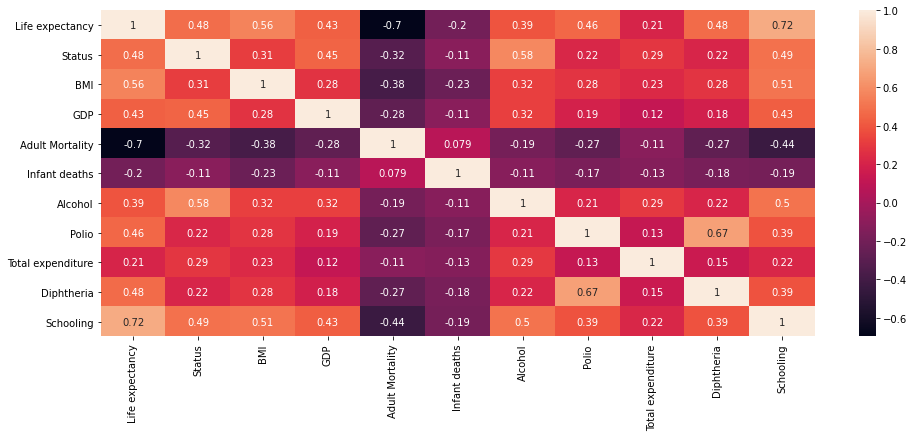

In [ ]:
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(method='pearson'), annot=True)

## Step 6

Build regression model and make an analysis of multicollinearity and regularization (if
needed).

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
ols_data = data[["Life expectancy", "GDP", "Diphtheria", "Adult Mortality", "Alcohol", "BMI"]]
# Spaces in variable names are not tolerated
ols_data = ols_data.rename({
    'Life expectancy': 'lifeexpectancy',
    'Adult Mortality': 'adultmortality',
    }, axis='columns')
print(ols_data.columns)
model = ols('lifeexpectancy ~ adultmortality + BMI + GDP + Alcohol + Diphtheria', data=ols_data).fit()
print(model.params)
print(model.summary())

Index(['lifeexpectancy', 'GDP', 'Diphtheria', 'adultmortality', 'Alcohol',
       'BMI'],
      dtype='object')
Intercept         61.411292
adultmortality    -0.036851
BMI                0.109494
GDP                0.000109
Alcohol            0.317239
Diphtheria         0.090028
dtype: float64
                            OLS Regression Results                            
Dep. Variable:         lifeexpectancy   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     1281.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        16:45:03   Log-Likelihood:                -9083.7
No. Observations:                2938   AIC:                         1.818e+04
Df Residuals:                    2932   BIC:                         1.822e+04
Df Model:                           5                                    

In [ ]:
model.get_influence().summary_frame().describe()

,dfb_Intercept,dfb_adultmortality,dfb_BMI,dfb_GDP,dfb_Alcohol,dfb_Diphtheria,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
count,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,4.344279e-07,0.000002,0.000004,-0.000008,0.000003,-0.000005,4.334423e-04,-0.000052,0.002042,-0.001018,-0.000225,-0.001026
std,3.079761e-02,0.024896,0.023365,0.017575,0.017924,0.026413,1.176853e-03,1.000444,0.001854,0.050995,1.001359,0.051038
min,-2.774525e-01,-0.200746,-0.145680,-0.358733,-0.144218,-0.164389,7.283150e-12,-5.201423,0.000443,-0.372205,-5.224697,-0.372505
25%,-1.842709e-03,-0.006850,-0.005142,-0.003495,-0.005924,-0.002495,1.152307e-05,-0.463470,0.001023,-0.018513,-0.463408,-0.018511
50%,3.350068e-04,-0.000905,-0.000025,-0.000234,-0.000331,0.000187,6.045648e-05,0.048487,0.001504,0.001784,0.048479,0.001783
75%,5.339501e-03,0.001036,0.005166,0.002798,0.004969,0.004282,3.089394e-04,0.564504,0.002327,0.019510,0.564438,0.019508
max,1.798038e-01,0.164961,0.161771,0.175070,0.113826,0.257459,2.308945e-02,3.442246,0.030685,0.265823,3.448635,0.266061


Condition number:

In [ ]:
np.linalg.cond(model.model.exog)

71496.25424536079

## Step 7

Analyze the quality of regression model (distribution of residuals, determination
coefficient).

In [ ]:
from sklearn.metrics import r2_score
print("R2 score:", 
      r2_score(ols_data['lifeexpectancy'], model.predict(ols_data)))

R2 score: 0.685935297570301


In [ ]:
def plot_residuals(data, var, model):
  residuals = data[var] - model.predict(data)

  plt.figure(figsize=(10, 8))   
  min_var, max_var = residuals.min(), residuals.max()
  x = np.linspace(min_var, max_var, len(residuals))
  sns.distplot(residuals, kde=False, norm_hist=True,
               label=f'Distribution of residuals for ' + var)
  plt.legend()
  plt.show()

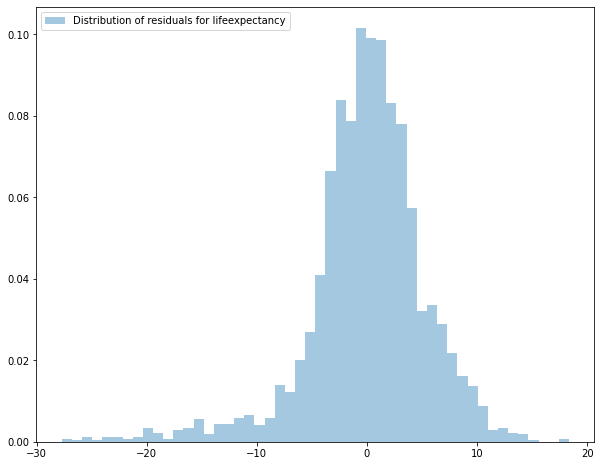

In [ ]:
plot_residuals(ols_data, 'lifeexpectancy', model)